In [1]:
library('corrplot')
library('ggplot2')

library('BMA') 
library('Amelia')
library('caret')

corrplot 0.92 loaded

Loading required package: survival

Loading required package: leaps

Loading required package: robustbase


Attaching package: 'robustbase'


The following object is masked from 'package:survival':

    heart


Loading required package: inline

Loading required package: rrcov

Scalable Robust Estimators with High Breakdown Point (version 1.6-2)


Loading required package: Rcpp


Attaching package: 'Rcpp'


The following object is masked from 'package:inline':

    registerPlugin


## 
## Amelia II: Multiple Imputation
## (Version 1.8.0, built: 2021-05-26)
## Copyright (C) 2005-2022 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:survival':

    cluster




In [2]:
mydata = read.csv('binary.csv')

head(mydata)

,admit,gre,gpa,rank
,<int>,<int>,<dbl>,<int>
1,0,380,3.61,3
2,1,660,3.67,3
3,1,800,4.00,1
4,1,640,3.19,4
5,0,520,2.93,4
6,1,760,3.00,2


In [3]:
# cols = colnames(mydata)

# # features selection
# yvar = mydata[, ('rank')] # biến target
# xvars = mydata[, cols[-1]] # biến predict

# bma = bicreg(xvars, yvar, strict = F, OR = 2)
# # bma

# print(summary(bma))

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

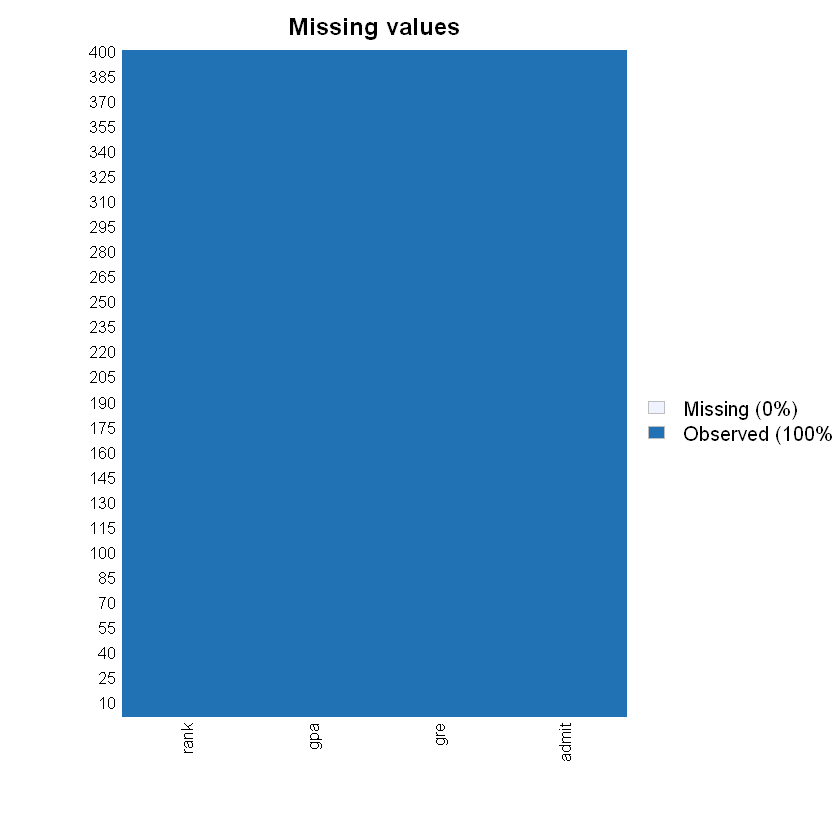

In [4]:
library('Amelia')
missmap(mydata, main = 'Missing values')

In [5]:
# ko có giá trị nào missing hết á

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [6]:
table(mydata$admit)


  0   1 
273 127 

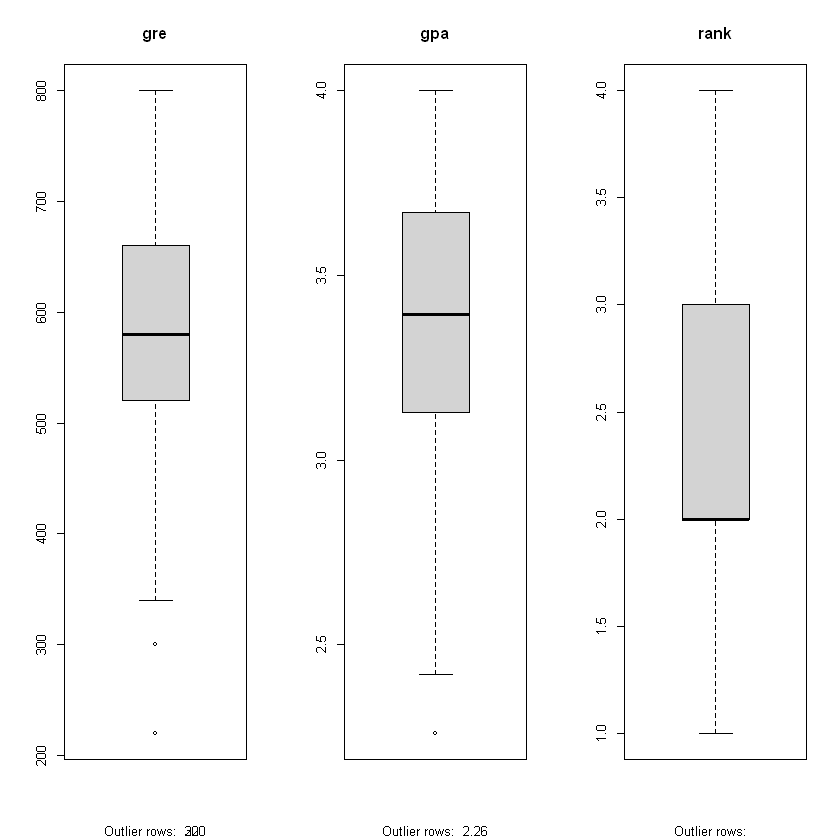

In [7]:
par(mfcol = c(1,3))
boxplot(mydata$gre, main = "gre",
        sub = paste("Outlier rows: ", boxplot.stats(mydata$gre)$out))
boxplot(mydata$gpa, main = "gpa",
        sub = paste("Outlier rows: ", boxplot.stats(mydata$gpa)$out))
boxplot(mydata$rank, main = "rank",
        sub = paste("Outlier rows: ", boxplot.stats(mydata$rank)$out))



In [8]:
gre_outliers = boxplot.stats(mydata$gre)$out
gpa_outliers = boxplot.stats(mydata$gpa)$out

print('gre_outlier')
print(gre_outliers)
print(paste('num rows', sum(mydata$gre == gre_outliers)))

print('gpa_outlier')
print(gpa_outliers)
print(paste('num rows', sum(mydata$gpa %in% gpa_outliers)))

# drop outliers
mydata = mydata[!(mydata$gre %in% gre_outliers),]
mydata = mydata[!(mydata$gpa %in% gpa_outliers),]

print(paste('after drop: ', nrow(mydata)))

[1] "gre_outlier"
[1] 300 300 220 300
[1] "num rows 3"
[1] "gpa_outlier"
[1] 2.26
[1] "num rows 1"
[1] "after drop:  395"


            gre         gpa        rank
gre   1.0000000  0.35937135 -0.10785090
gpa   0.3593714  1.00000000 -0.03994452
rank -0.1078509 -0.03994452  1.00000000


Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
""moethod" is not a graphical parameter"
Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
""moethod" is not a graphical parameter"
Warning message in title(title, ...):
""moethod" is not a graphical parameter"


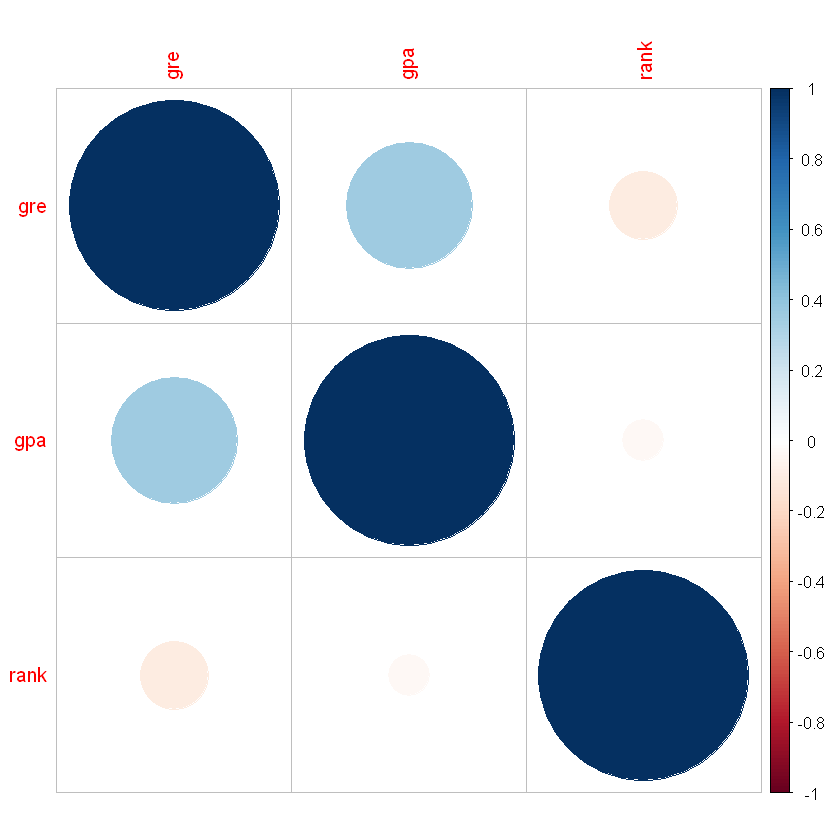

In [9]:
correlations = cor(mydata[,2:4])
print(correlations)
corrplot(correlations, moethod = 'circle')

In [10]:
# các biến inputs khá ko tương quan vs nhau => ko xảy ra hiện tượng đa cộng tuyến

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [11]:
# tao train/test
set.seed(42)
trainingRowIndex <- sample(1:nrow(mydata), 0.8*nrow(mydata))
# trainingRowIndex

#train data
trainData <- mydata[trainingRowIndex, ]
nrow(trainData)

#test
testData <- mydata[-trainingRowIndex, ]
nrow(testData)

[1] 316

[1] 79

In [12]:
mylogit = glm(admit ~ gre+gpa+rank, data = trainData, family='binomial')

print(summary(mylogit))


Call:
glm(formula = admit ~ gre + gpa + rank, family = "binomial", 
    data = trainData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5146  -0.9127  -0.6655   1.1619   2.0920  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.417768   1.257693  -2.717 0.006578 ** 
gre          0.001081   0.001234   0.876 0.380891    
gpa          0.963849   0.364246   2.646 0.008141 ** 
rank        -0.508816   0.138254  -3.680 0.000233 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 401.81  on 315  degrees of freedom
Residual deviance: 375.05  on 312  degrees of freedom
AIC: 383.05

Number of Fisher Scoring iterations: 4



In [13]:
pred = predict(mylogit, newdata = testData, type = 'response')
pred_value = ifelse(pred>0.5, 1, 0)

print('Testdata admit vs predict: (20 rows)')
res = data.frame(testAdmit = testData$admit[20:40], pred_value[20:40])
head(res)

[1] "Testdata admit vs predict: (20 rows)"


,testAdmit,pred_value.20.40.
,<int>,<dbl>
102,0,0
105,1,1
118,0,0
120,0,0
124,0,0
132,0,0


### **Evaluation**

In [14]:
library('caret')

In [15]:
# cách 1
acc = table(pred_value, testData[, 'admit'])
acc = sum(diag(acc))/sum(acc)
print(paste('acc1: ', acc))

# cách 2
misClasificError = mean(pred_value != testData$admit)
acc2 = 1 - misClasificError
print(paste('acc2: ', acc2))


[1] "acc1:  0.746835443037975"
[1] "acc2:  0.746835443037975"


In [17]:
confusionMatrix(as.factor(pred_value), as.factor(testData$admit))

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 53 15
         1  5  6
                                         
               Accuracy : 0.7468         
                 95% CI : (0.6364, 0.838)
    No Information Rate : 0.7342         
    P-Value [Acc > NIR] : 0.45722        
                                         
                  Kappa : 0.2352         
                                         
 Mcnemar's Test P-Value : 0.04417        
                                         
            Sensitivity : 0.9138         
            Specificity : 0.2857         
         Pos Pred Value : 0.7794         
         Neg Pred Value : 0.5455         
             Prevalence : 0.7342         
         Detection Rate : 0.6709         
   Detection Prevalence : 0.8608         
      Balanced Accuracy : 0.5998         
                                         
       'Positive' Class : 0              
                                         

### **Dự đoán giá trị mới**

In [16]:
y1 = predict(mylogit, newdata = data.frame(gre = 800,
                                            gpa = 6,
                                            rank = 2),
                        type = 'response'
)

In [17]:
y1 = ifelse(y1>0.5, 1,0)
print('result: ')
print(y1)

[1] "result: "
1 
1 
